In [3]:
import xarray as xr
import numpy as np
import pandas as pd
from numpy import datetime64
from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from numpy.fft import *

In [4]:
from esdl.cube_store import CubesStore
cs = CubesStore()
cs

CUBE_V2.0.0_global_spatially_optimized_0.25deg,Global data cube at a spatial resolution of 0.25 degrees and a temporal resolution of 8 days with a 1x720x1440 (time x lat x lon) chunking
CUBE_V2.0.0_global_time_optimized_0.25deg,Global data cube at a spatial resolution of 0.25 degrees and a temporal resolution of 8 days with a 184x90x90 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_spatially_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.0_global_spatially_optimized_0.083deg,Global data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x2160x4320 (time x lat x lon) chunking
CUBE_V2.0.0_global_time_optimized_0.083deg,Global data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 184x270x270 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_spatially_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.0083 degrees and a temporal resolution of 8 days with a 1x3360x2760 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_time_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.0083 degrees and a temporal resolution of 8 days with a 184x60x60 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_spatially_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_time_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_spatially_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_time_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking


In [6]:
data=cs['CUBE_V2.0.1_colombia_time_optimized_0.083deg']

In [7]:
from numpy.fft import fft, ifft, fftfreq, rfftfreq, rfft, irfft

#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    #random date to get the mask map
    #date='2000-11-28'
    #leave only land==2
    #area_to_explore=area_to_explore.where(area_to_explore.mask.sel(time=date)==2)
    #mask=cube.mask.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage < threshold):
            print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube,lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    for feature in features:
        series.append(clean_feature(cube_section, feature))
    
    #return pd.concat(series, axis=1)
    return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name, fourier_threshold = 8):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series

In [8]:
test=data.copy()
test.evapotranspiration
ET=test.evapotranspiration
#ET.sel(lat=0).plot()

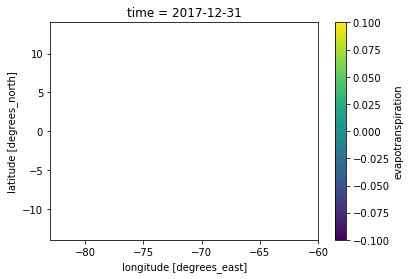

In [9]:
ET.sel(time='2017-12-31').plot()

In [10]:
ET['time']

<xarray.DataArray 'time' (time: 782)>
array(['2001-01-05T00:00:00.000000000', '2001-01-13T00:00:00.000000000',
       '2001-01-21T00:00:00.000000000', ..., '2017-12-15T00:00:00.000000000',
       '2017-12-23T00:00:00.000000000', '2017-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2017-12-31
Attributes:
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [11]:
nanmeanlat=ET.reduce(np.nanmean,dim='lat')
nanmeanlon=nanmeanlat.reduce(np.nanmean,dim='lon')
print(nanmeanlon)
nonnantime=nanmeanlon.dropna(dim='time')
nonnantimemean=nonnantime.reduce(np.mean,dim='time')
print(nonnantimemean)
fullmeanshort=nanmeanlon.sel(time=slice('2001-01-05','2015-12-31')).reduce(np.mean,dim='time')
print(fullmeanshort)

<xarray.DataArray 'evapotranspiration' (time: 782)>
array([2.740693, 2.609186, 2.477775, ...,      nan,      nan,      nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2017-12-31
<xarray.DataArray 'evapotranspiration' ()>
array(2.786007, dtype=float32)
<xarray.DataArray 'evapotranspiration' ()>
array(2.786007, dtype=float32)


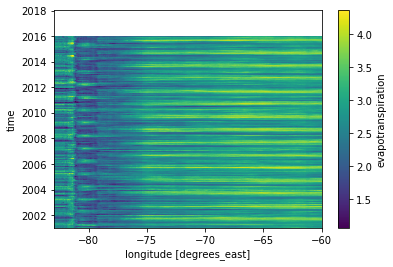

In [12]:
nantime=ET.reduce(np.nanmedian,dim='lat')
nantime.reduce(fft,dim='lon')
nantime.plot()

In [19]:
little=ET.sel(lat=slice(5-0.04131,-0.04131-5),lon=slice(-3-69.96,3-69.96),time=slice('2001-01-05','2015-12-31'))

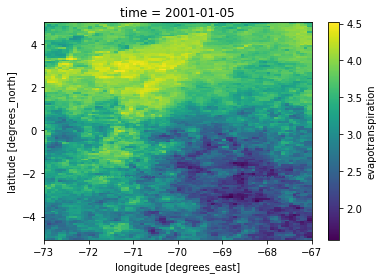

In [20]:
little.sel(time='2001-01-05').plot()

In [21]:
little.load()

<xarray.DataArray 'evapotranspiration' (time: 690, lat: 121, lon: 72)>
array([[[3.581   , 3.699   , ..., 3.503   , 3.424   ],
        [3.629   , 3.226263, ..., 3.838   , 3.569   ],
        ...,
        [3.194   , 2.994   , ..., 1.983   , 1.739   ],
        [3.007   , 2.755   , ..., 2.532   , 2.396   ]],

       [[3.372   , 3.655   , ..., 2.914   , 3.22    ],
        [3.648   , 3.273737, ..., 3.55    , 3.195   ],
        ...,
        [2.752   , 2.515   , ..., 2.587   , 2.676   ],
        [2.7     , 2.846   , ..., 2.311   , 2.396   ]],

       ...,

       [[3.072   , 3.254   , ..., 3.004   , 2.858   ],
        [3.179   , 3.383838, ..., 3.109   , 2.895   ],
        ...,
        [2.291   , 2.335   , ..., 2.766   , 2.747   ],
        [2.038   , 2.3     , ..., 2.656   , 3.024   ]],

       [[2.872   , 2.908   , ..., 2.924   , 2.638   ],
        [2.958   , 2.793939, ..., 2.856   , 2.397   ],
        ...,
        [2.123   , 2.149   , ..., 2.838   , 3.114   ],
        [2.232   , 2.21    , ...,

In [25]:
change=ET.sel(lat=slice(5-0.04131,-0.04131-5),lon=slice(-3-69.96,3-69.96)).copy()

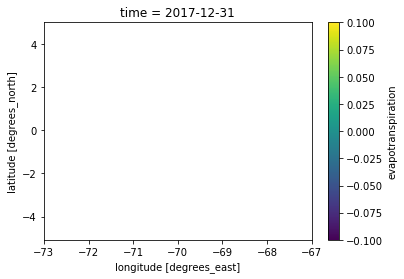

In [125]:
change[-1,:,:].plot()

In [126]:
change[-1,10,:]=100

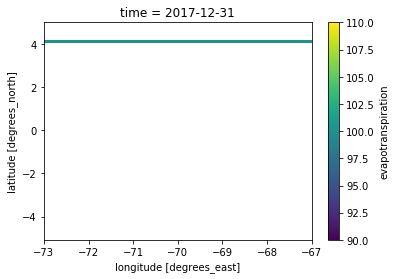

In [127]:
change[-1,:,:].plot()
#orden= [time,lat,lon]

In [28]:
fourierData=little.copy()
fourierData.rename({'time':'freq'})
fourierData.load()

<xarray.DataArray 'evapotranspiration' (time: 690, lat: 121, lon: 72)>
array([[[3.581   , 3.699   , ..., 3.503   , 3.424   ],
        [3.629   , 3.226263, ..., 3.838   , 3.569   ],
        ...,
        [3.194   , 2.994   , ..., 1.983   , 1.739   ],
        [3.007   , 2.755   , ..., 2.532   , 2.396   ]],

       [[3.372   , 3.655   , ..., 2.914   , 3.22    ],
        [3.648   , 3.273737, ..., 3.55    , 3.195   ],
        ...,
        [2.752   , 2.515   , ..., 2.587   , 2.676   ],
        [2.7     , 2.846   , ..., 2.311   , 2.396   ]],

       ...,

       [[3.072   , 3.254   , ..., 3.004   , 2.858   ],
        [3.179   , 3.383838, ..., 3.109   , 2.895   ],
        ...,
        [2.291   , 2.335   , ..., 2.766   , 2.747   ],
        [2.038   , 2.3     , ..., 2.656   , 3.024   ]],

       [[2.872   , 2.908   , ..., 2.924   , 2.638   ],
        [2.958   , 2.793939, ..., 2.856   , 2.397   ],
        ...,
        [2.123   , 2.149   , ..., 2.838   , 3.114   ],
        [2.232   , 2.21    , ...,

In [31]:
tryFourier=little.rename({'time':'freq'})
tryFourier

<xarray.DataArray 'evapotranspiration' (freq: 690, lat: 121, lon: 72)>
array([[[3.581   , 3.699   , ..., 3.503   , 3.424   ],
        [3.629   , 3.226263, ..., 3.838   , 3.569   ],
        ...,
        [3.194   , 2.994   , ..., 1.983   , 1.739   ],
        [3.007   , 2.755   , ..., 2.532   , 2.396   ]],

       [[3.372   , 3.655   , ..., 2.914   , 3.22    ],
        [3.648   , 3.273737, ..., 3.55    , 3.195   ],
        ...,
        [2.752   , 2.515   , ..., 2.587   , 2.676   ],
        [2.7     , 2.846   , ..., 2.311   , 2.396   ]],

       ...,

       [[3.072   , 3.254   , ..., 3.004   , 2.858   ],
        [3.179   , 3.383838, ..., 3.109   , 2.895   ],
        ...,
        [2.291   , 2.335   , ..., 2.766   , 2.747   ],
        [2.038   , 2.3     , ..., 2.656   , 3.024   ]],

       [[2.872   , 2.908   , ..., 2.924   , 2.638   ],
        [2.958   , 2.793939, ..., 2.856   , 2.397   ],
        ...,
        [2.123   , 2.149   , ..., 2.838   , 3.114   ],
        [2.232   , 2.21    , ...,

In [33]:
for latitude in range(len(tryFourier['lat'].values)):
    for longitude in range(len(tryFourier['lon'].values)):
        timeSeries=tryFourier[:,latitude,longitude].values
        normSeries=(timeSeries-np.mean(timeSeries))/np.std(timeSeries)
        fourierSeries=np.abs(fft(normSeries))
        tryFourier[:,latitude,longitude]=fourierSeries

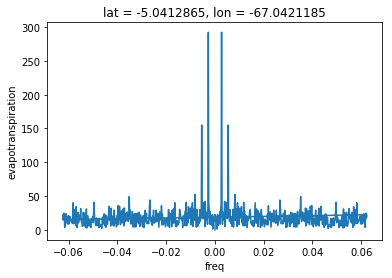

In [51]:
tryFourier.coords['freq']=fftfreq(len(tryFourier.sel(lat=0,lon=0,method='nearest').values),8)
freqs = fftfreq(len(tryFourier.sel(lat=0,lon=0,method='nearest').values),8)
tryFourier.sel(lat=-50,lon=-50,method='nearest').plot()

In [57]:
maxCoef=Nmax(list(tryFourier.sel(lat=-50,lon=-50,method='nearest').values),10)
indexes = find_Index(tryFourier.sel(lat=-50,lon=-50,method='nearest').values,maxCoef)
maxCoef,freqs[indexes]**-1/30

([292.30167,
  292.30167,
  155.03047,
  155.03047,
  52.705357,
  52.705357,
  49.391483,
  49.391483,
  44.164165,
  44.164165],
 array([12.26666667, 12.26666667,  6.13333333,  6.13333333,  4.08888889,
         4.08888889,  0.94845361,  0.94845361,  1.25170068,  1.25170068]))